<a href="https://colab.research.google.com/github/trishamediana/HodgkinHuxley_Action_Potential/blob/main/Hodgkin_Huxley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera  # A module that will allow us to do plotting animations
from scipy.integrate import solve_ivp  # This function will help with solving differential equations

In [ ]:
class Neuron():
    """Hudgkin & Huxley Model of the excitable cell"""
    def __init__(self, voltage, sodium, potassium, leak):
        """This instantiates a Neuron object with the following properties
        sodium, potassium and leak should be dictionaries with their conductance
        and equilibrium potential as elements.
        """
        self.voltage = voltage
        self.Gna, self.Ena = sodium['G'], sodium['Eq']
        self.Gk, self.Ek = potassium['G'], potassium['Eq']
        self.Gl, self.El = leak['G'], leak['Eq']

    def __str__(self):
        """This lets the Neuron Object be used by the print() function"""
        return "Hello ! I'm Hudgkin & Huxley Model"

    def an(self, volt):
        """alpha_n in function of voltage, potassium channel constant"""
        return 0.01 * (10 - volt) / (np.exp((10. - volt) / 10.) - 1.)

    def bn(self, volt):
        """beta_n in function of voltage, potassium channel constant"""
        return 0.125 * np.exp(-volt / 80.)

    def am(self, volt):
        """alpha_m in function of voltage, sodium channel constant"""
        return 0.1 * (25. - volt) / (np.exp((25. - volt) / 10.) - 1.)

    def bm(self, volt):
        """beta_m in function of voltage, sodium channel constant"""
        return 4. * np.exp(-volt / 18.)

    def ah(self, volt):
        """alpha_h in function of voltage, sodium channel constant"""
        return 0.07 * np.exp(-volt / 20.)

    def bh(self, volt):
        """beta_h in function of voltage, sodium channel constant"""
        return 1. / (np.exp((30. - volt) / 10.) + 1.)

    def tau(self, alpha, beta):
        """this method calculates the time constant tau 
        for a certain ion channel.
        """
        return 1. / (alpha + beta)

    def finfty(self, alpha, beta):
        """this method calculates the stationary constant
        f_infty for a certain ion channel.
        """
        return alpha / (alpha + beta)

    def INa(self):
        """this calculates the sodium transient current using previous class methods."""
        m = self.finfty(self.am(self.voltage), self.bm(self.voltage))
        h = self.finfty(self.ah(self.voltage), self.bh(self.voltage))

        return self.Gna * m**3. * h * (
            self.voltage - self.Ena
        )  # Ohm's law for ion channels I = G*(V - Eeq)

    def IK(self):
        """this calculates the potassium persistant current using previous class methods."""
        n = self.finfty(self.an(self.voltage), self.bn(self.voltage))

        return self.Gk * n**4. * (
            self.voltage - self.Ek
        )  # Ohm's law for ion channels I = G*(V - Eeq)

    def IL(self):
        """this calculates the leak channel current."""
        return self.Gl * (self.voltage - self.El)

    def simulate(self, V_init, n_init, m_init, h_init, Tmax, inj=0):
        """This method simulates the H&H model starting from initial conditions
        given as parameters for a given period of time Tmax, it uses scipy.integrate.solve_ivp()
        function to solve the system of four differential equations.
        """
        def hudgkin_huxley(t, vars):
            """The four nonlinear differential equations should be wrapped inside a function."""
            V, n, m, h = vars
            return [
                -self.Gna * m**3 * h * (V - self.Ena) - self.Gk * n**4 *
                (V - self.Ek) - self.Gl * (V - self.El) + inj,
                (self.an(V) * (1 - n)) - (self.bn(V) * n),
                (self.am(V) * (1 - m)) - (self.bm(V) * m),
                (self.ah(V) * (1 - h)) - (self.bh(V) * h)
            ]

        solution = solve_ivp(
            hudgkin_huxley,
            [0, Tmax],  # Solve the system 
            (V_init, n_init, m_init, h_init),  # Initial conditions as a tuple
            t_eval=np.linspace(0, Tmax, 250))

        tt, vt, nt, mt, ht = solution.t, solution.y[0], solution.y[
            1], solution.y[2], solution.y[3]  # Seperate the solutions

        # Now let's calculate currents and conductances based on the solutions
        GNA, INA = self.Gna * mt**3 * ht, self.Gna * mt**3 * ht * (vt -
                                                                   self.Ena)
        GK, IK = self.Gk * nt**4, self.Gk * nt**4 * (vt - self.Ek)
        IL = self.Gl * (vt - self.El)

        # Now let's start the plotting and the animation process
        fig, axes = plt.subplots(1, 3, figsize=(12, 5), dpi=150)
        cam4 = Camera(fig)
        for s in range(len(vt)):
            l1, = axes[0].plot(tt[:s], vt[:s], 'g', linestyle='solid')
            axes[0].legend([l1], [r'$V(t)$'])  # V(t) in function of time

            i1, i2, i3 = axes[1].plot(
                tt[:s],
                INA[:s],
                'y',
                tt[:s],
                IK[:s],
                'r',
                tt[:s],
                IL[:s],
                'b',
                linestyle='solid')  # Currents in fucntion of time
            axes[1].set_xlabel('Time')
            axes[1].legend([i1, i2, i3],
                           [r'$I_{Na^+}$', r'$I_{K^+}$', r'$I_{L}$'])
            axes[1].set_title("""Hudgkin & Huxley Model Simulation,
                Initial conditions : $V$ = %s, $n$ = %s, $m$ = %s, $h$ = %s, $T_{max}$ = %s, $I_{injected}$ = %s"""
                              % (V_init, n_init, m_init, h_init, Tmax, inj))

            g1, g2 = axes[2].plot(
                tt[:s], GNA[:s], 'y', tt[:s], GK[:s], 'r',
                linestyle='solid')  # Conductances in function of time
            axes[2].legend([g1, g2], [r'$g_{Na^+}$', r'$g_{K^+}$'])
            cam4.snap()
        cam4.animate(blit=False, interval=30,
                     repeat=True).save('HHsimulation.mp4')

In [ ]:
Na = {'G' : 120., 'Eq' : 120.}
K = {'G' : 36., 'Eq' : -12.}
Leak = {'G' : 0.3,'Eq' :10.6}

In [ ]:
v = np.linspace(-150, 150, 100)

In [ ]:
cell = Neuron(voltage=v, sodium=Na, potassium=K, leak=Leak)

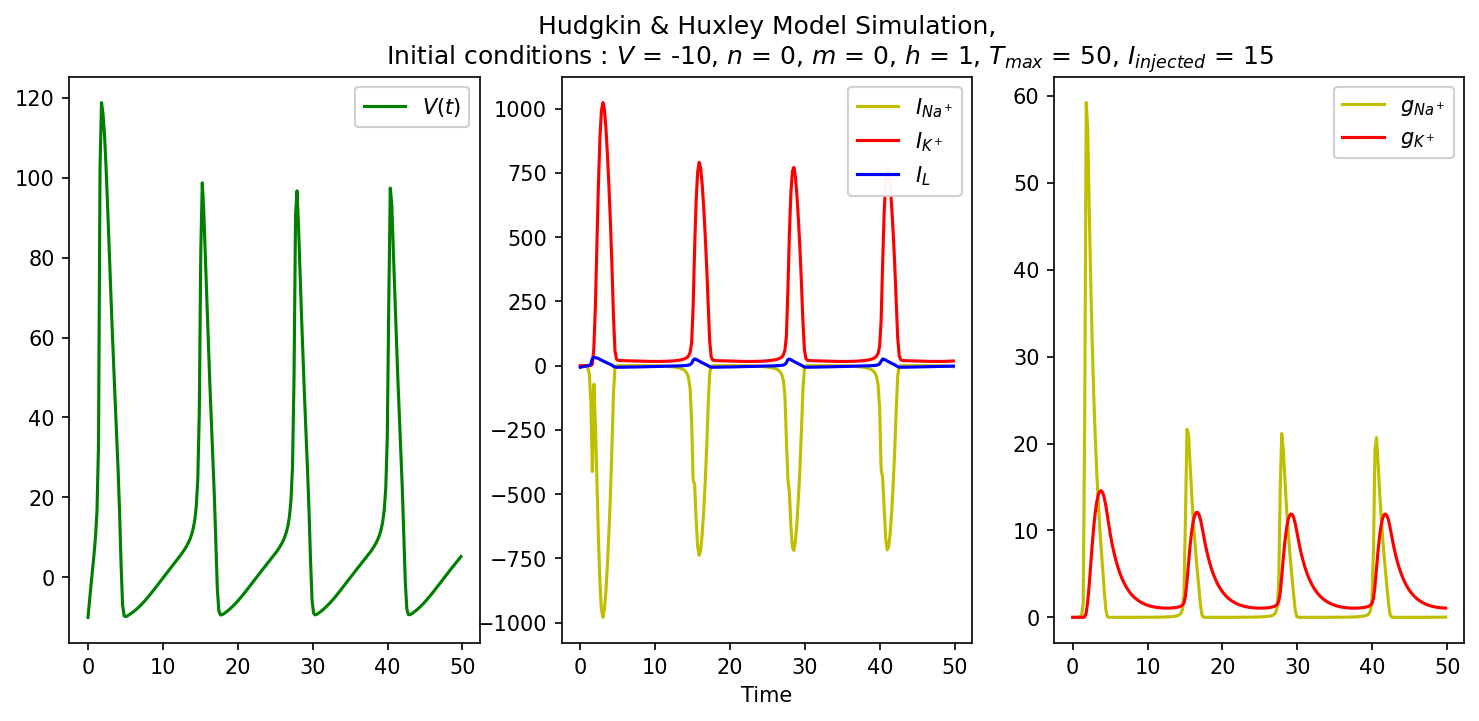

In [ ]:

cell.simulate(V_init=-10, n_init=0, m_init=0, h_init=1, Tmax=50, inj = 15)